In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data = pd.read_csv('../Data/df_skill.csv')
data.drop('Unnamed: 0',axis = 1,inplace=True)

In [3]:
data.drop(['microsoft_office', 'microsoft_word', 'microsoft_excel', 'management', 'project_management','change_management'], axis = 1, inplace=True)

In [ ]:
freq = (data>0).apply(sum).values
data = data * (1/(1+np.log(freq)))

drop_list = []
for i in range(len(freq)):
    if freq[i] == 1:
        drop_list.append(data.columns[i])
data.drop(drop_list, axis = 1, inplace=True)

In [ ]:
data.shape

In [ ]:
data.info(0)

In [2]:
data = pd.read_csv('../Notebook/skill_vectors.csv')

In [ ]:
data.shape

In [ ]:
#tf_data = tf.constant(data.values, dtype=tf.float32)

In [ ]:
learning_rate = 0.01
training_epochs = 10
batch_size = 400
display_step = 1
examples_to_show = 10

In [ ]:
n_input = data.shape[1]

tf.set_random_seed(50)

X = tf.placeholder(tf.float32,[None, n_input])

n_hidden_layer1 = 64#1024
n_hidden_layer2 = 8#256
n_hidden_layer3 = 2#64
#n_hidden_layer4 = 8
#n_hidden_layer5 = 2


In [ ]:
weights = {
    'encoder_w1':tf.Variable(tf.random_normal([n_input, n_hidden_layer1])),
    'encoder_w2':tf.Variable(tf.random_normal([n_hidden_layer1, n_hidden_layer2])),
    'encoder_w3':tf.Variable(tf.random_normal([n_hidden_layer2, n_hidden_layer3])),
    #'encoder_w4':tf.Variable(tf.random_normal([n_hidden_layer3, n_hidden_layer4])),#
    #'encoder_w5':tf.Variable(tf.random_normal([n_hidden_layer4, n_hidden_layer5])),#
    
    #'decoder_w1':tf.Variable(tf.random_normal([n_hidden_layer5, n_hidden_layer4])),#
    #'decoder_w2':tf.Variable(tf.random_normal([n_hidden_layer4, n_hidden_layer3])),#
    #'decoder_w3':tf.Variable(tf.random_normal([n_hidden_layer3, n_hidden_layer2])),#
    #'decoder_w4':tf.Variable(tf.random_normal([n_hidden_layer2, n_hidden_layer1])),#
    #'decoder_w5':tf.Variable(tf.random_normal([n_hidden_layer1, n_input])),#
    'decoder_w1':tf.Variable(tf.random_normal([n_hidden_layer3, n_hidden_layer2])),
    'decoder_w2':tf.Variable(tf.random_normal([n_hidden_layer2, n_hidden_layer1])),
    'decoder_w3':tf.Variable(tf.random_normal([n_hidden_layer1, n_input])),
}

biases = {
    'encoder_b1':tf.Variable(tf.random_normal([n_hidden_layer1], seed=20)),
    'encoder_b2':tf.Variable(tf.random_normal([n_hidden_layer2], seed=20)),
    'encoder_b3':tf.Variable(tf.random_normal([n_hidden_layer3], seed=20)),
    #'encoder_b4':tf.Variable(tf.random_normal([n_hidden_layer4])),#
    #'encoder_b5':tf.Variable(tf.random_normal([n_hidden_layer5])),#
    
    #'decoder_b1':tf.Variable(tf.random_normal([n_hidden_layer4])),#
    #'decoder_b2':tf.Variable(tf.random_normal([n_hidden_layer3])),#
    #'decoder_b3':tf.Variable(tf.random_normal([n_hidden_layer2])),#
    #'decoder_b4':tf.Variable(tf.random_normal([n_hidden_layer1])),#
    #'decoder_b5':tf.Variable(tf.random_normal([n_input])),#
    'decoder_b1':tf.Variable(tf.random_normal([n_hidden_layer2])),
    'decoder_b2':tf.Variable(tf.random_normal([n_hidden_layer1])),
    'decoder_b3':tf.Variable(tf.random_normal([n_input])),
}

In [ ]:
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_w1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_w2']), biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_w3']), biases['encoder_b3']))
    #layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['encoder_w4']), biases['encoder_b4']))#
    #layer_5 = tf.nn.sigmoid(tf.add(tf.matmul(layer_4, weights['encoder_w5']), biases['encoder_b5']))#
    #return layer_5#
    return layer_3

def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_w1']), biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_w2']), biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_w3']), biases['decoder_b3']))
    #layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['decoder_w4']), biases['decoder_b4']))#
    #layer_5 = tf.nn.sigmoid(tf.add(tf.matmul(layer_4, weights['decoder_w5']), biases['decoder_b5']))#
    #return layer_5
    return layer_3

In [ ]:
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

y_pred = decoder_op
y_true = X

cost = tf.reduce_mean(tf.pow(y_pred - y_true, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
%%time
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    n_batch = int(data.shape[0]/batch_size)
    for epoch in tqdm(range(training_epochs)):
        for batch_idx in range(n_batch):
            start = batch_idx * batch_size
            stop = start + batch_size
            _, encoder_result = sess.run([optimizer, encoder_op], feed_dict={X: data[start:stop]})
    #print(sess.run(cost, feed_dict={X:data[start:stop]}))
    X_test = sess.run(encoder_op, feed_dict={X:data})

In [ ]:
plt.scatter(X_test[:,0],X_test[:,1])
plt.show()
X_test.shape

In [ ]:
type(X_test)

In [ ]:
#from sklearn.cluster import SpectralClustering
#clustering = SpectralClustering(n_clusters=2,assign_labels="discretize", random_state=0).fit(X_test)

In [4]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('../Utils/word2vec_model_allskills')

D:\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
import dill as pickle
f = open("../Data/all_top_skills_final_fre.txt","rb")
key_list = pickle.load(f)
f.close()


skill_list = []
for i in key_list.keys():
    try: 
        model[i]
        skill_list.append(i)
    except:
        pass

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [6]:
X_test

NameError: name 'X_test' is not defined

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering_agg = AgglomerativeClustering(n_clusters=50,linkage='average')

In [ ]:
result_agg = clustering_agg.fit_predict(X_test)
for i in range(50):
    list_x = []
    list_y = []
    for j in range(len(result_agg)):
        if result_agg[j] == i:
            list_x.append(X_test[j,0])
            list_y.append(X_test[j,1])
    plt.scatter(list_x,list_y)
plt.show()

In [ ]:
clustering_agg = AgglomerativeClustering(n_clusters=50,linkage='average')
result_agg = clustering_agg.fit_predict(data)
for i in range(50):
    list_x = []
    list_y = []
    for j in range(len(result_agg)):
        if result_agg[j] == i:
            list_x.append(X_test[j,0])
            list_y.append(X_test[j,1])
    plt.scatter(list_x,list_y)
plt.show()

In [ ]:
from collections import Counter
skill_counts = Counter(result_agg)
top_three = skill_counts.most_common(3)
top_three

In [ ]:
for i in range(50):
    if i != top_three[0][0]:
        list_temp = []
        for j in range(len(result_agg)):
            if result_agg[j] == i:
                list_temp.append(skill_list[j])
        print(list_temp)
        print("  ")

In [ ]:
%%time
from sklearn.mixture import GaussianMixture
clustering = GaussianMixture(n_components=500,covariance_type='spherical',init_params='random').fit(X_test)

In [ ]:
result = clustering.predict(X_test)
for i in range(500):
    if sum(result == i) > 0:
        print(str(sum(result == i))+"  "+str(i))

In [ ]:
import bson
with open("../Data/linkedin_db/profile.bson",'rb') as f: 
    data_profile = bson.decode_all(f.read()) 
    f.close()

In [ ]:
def show_skill(index):
    show = [[],[]]
    show[0].append('Top Skills: ')
    show[1].append('Other Skills: ')
    for skills in data_profile[index]['skills']:
        if skills['title'] == 'Top Skills':
            for skill in skills['skills']:
                show[0].append(skill['title'])
        else:
            for skill in skills['skills']:
                show[1].append(skill['title'])
    print(show[0])
    #print(show[1])
    return

In [ ]:
import heapq
cluster1_index = []
for i in range(len(result)):
    if result[i] == 109:
        cluster1_index.append(i)

temp = np.zeros([data.shape[1]])
for i in cluster1_index:
    temp += data.loc[i].values 
    show_skill(i)

temp_list = temp.tolist()
max_index = heapq.nlargest(3, range(len(temp_list)), temp_list.__getitem__)
data.columns[max_index]

In [ ]:
key_list.keys()

In [ ]:
sorted(key_list.items(),key=lambda item:item[1],reverse=True)

In [ ]:
import dill as pickle
f = open("../Data/all_top_skills_final_fre.txt","rb")
key_list = pickle.load(f)
f.close()

In [ ]:
temp_list.index

In [ ]:
import heapq
max_index = heapq.nlargest(3, range(len(temp_list)), temp_list.__getitem__)
max_index

In [ ]:
list(temp)

In [ ]:
freq = (data>0).apply(sum).values
data = data * (1/(1+np.log(freq)))

In [ ]:
data.columns[freq.tolist().index(freq.max())]

In [ ]:
(1/(1+np.log(freq))).max()

In [ ]:
data = data * (1/(1+np.log(freq)))

In [ ]:
data

In [3]:
import sys
sys.path.append('../Project_PRIM/')

In [4]:
from my_functions import Autoencoder_test
ae = Autoencoder_test(data)

In [12]:
X_test2,_ = ae.encode()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.76it/s]


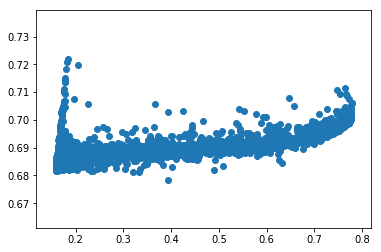

(6804, 2)

In [13]:
plt.scatter(X_test2[:,0],X_test2[:,1])
plt.show()
X_test2.shape